In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

data = pd.read_table('../data/all_Assistance_Delta_20191011_1.csv', sep=',', header=0)
edumask = (data['recipient_name'].str.contains('UNIV')) | (data['recipient_name'].str.contains('COLLEGE'))
data = data[edumask]

year_mask = data['action_date_fiscal_year'] > 2016
data = data[year_mask]
# remove multiple rows corresponding to several actions of the same award: we are only interested in the total award and
# ignore the individual transactions pertaining to the same award. 
# Pick last occurence -> see section on Tricky aspects of data above.
data.drop_duplicates(subset=['award_id_fain'], inplace=True, keep='last')
# remove non-positive funds since it is unclear how to interpret those.
#data = data[data['total_funding_amount'] > 0]

# define minimum columns to be able to perform a simple network analysis:
mincols = ['awarding_agency_name', 'recipient_name', 'federal_action_obligation', 'action_date', 'total_funding_amount']

## This is the actual dataset I'll operate on for the graph
all_data = data[mincols]


### Using federal_action_obligation

In [16]:
## Generate the graph and compute edge weights
G = nx.DiGraph()
edgelists = dict()
edge_weights = dict()
## Split the data so we can have edgeweights per funder
for agency in all_data.awarding_agency_name.unique():
    agency_data = all_data[all_data.awarding_agency_name == agency]
    edgelists[agency] = []

    ## Get the total weight for current agency across universities
    total_weight = sum([all_data[(all_data.recipient_name == name) & (all_data.awarding_agency_name == agency)].federal_action_obligation.sum() \
                         for name in all_data[all_data.awarding_agency_name == agency].recipient_name.unique()])

    for name in agency_data.recipient_name.unique():
        ## Get the total funds for current university from current agency
        weight = agency_data[agency_data.recipient_name == name].federal_action_obligation.sum()
        ## Filter weights by percentage of total agency funds
        #if weight > total_weight*.01:
        G.add_edge(agency, name, weight = weight)
        edgelists[agency].append((agency, name))

    ## Normalize edge weights to be between 0,1 to use consistent color map
    edge_weights[agency] = np.array([data['weight'] for e1,e2, data in G.edges(data=True) if (e1, e2) in edgelists[agency]])
    #edge_weights[agency] = (edge_weights[agency] - edge_weights[agency].min()) / (edge_weights[agency].max() - edge_weights[agency].min())

/Users/larock/miniconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


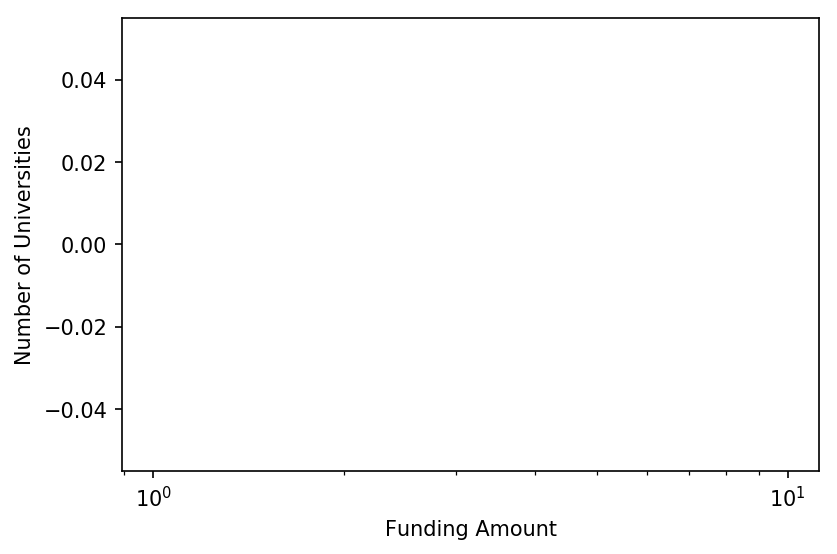

In [17]:
dod_weights = edge_weights['DEPARTMENT OF DEFENSE (DOD)']
min_val, max_val = min(dod_weights), max(dod_weights)
num_bins = 5
bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins+1)
x = bins[1:] - np.diff(bins)/2.0
y, _ = np.histogram(dod_weights, bins=bins, density=False)

plt.figure(dpi=150)
plt.plot(x, y, 'o')
plt.gca().set_xscale("log")
plt.ylabel("Number of Universities")
plt.xlabel('Funding Amount')
plt.show()

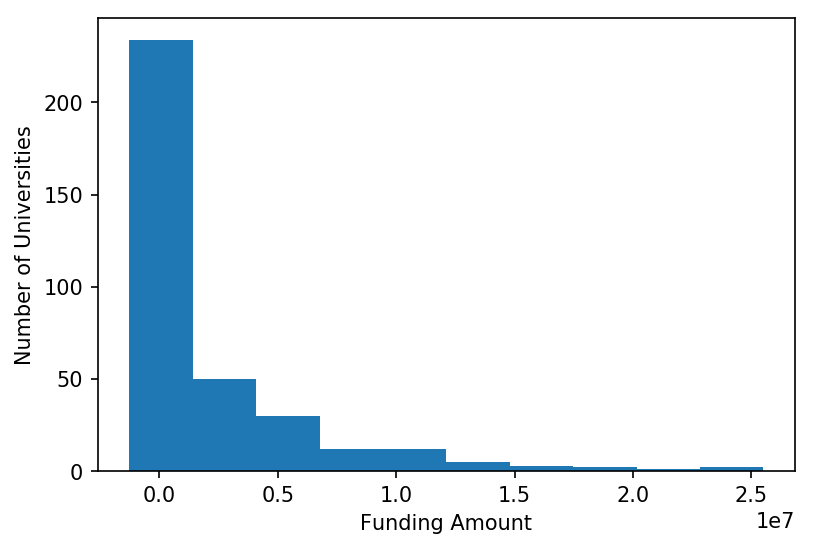

In [18]:
plt.figure(dpi=150)
plt.hist(dod_weights)
plt.ylabel("Number of Universities")
plt.xlabel('Funding Amount')
plt.show()

### Using total_funding_amount

In [19]:
## Generate the graph and compute edge weights
G = nx.DiGraph()
edgelists = dict()
edge_weights = dict()
## Split the data so we can have edgeweights per funder
for agency in all_data.awarding_agency_name.unique():
    agency_data = all_data[all_data.awarding_agency_name == agency]
    edgelists[agency] = []

    ## Get the total weight for current agency across universities
    total_weight = sum([all_data[(all_data.recipient_name == name) & (all_data.awarding_agency_name == agency)].total_funding_amount.sum() \
                         for name in all_data[all_data.awarding_agency_name == agency].recipient_name.unique()])

    for name in agency_data.recipient_name.unique():
        ## Get the total funds for current university from current agency
        weight = agency_data[agency_data.recipient_name == name].total_funding_amount.sum()
        ## Filter weights by percentage of total agency funds
        G.add_edge(agency, name, weight = weight)
        edgelists[agency].append((agency, name))

    ## Normalize edge weights to be between 0,1 to use consistent color map
    edge_weights[agency] = np.array([data['weight'] for e1,e2, data in G.edges(data=True) if (e1, e2) in edgelists[agency]])
    #edge_weights[agency] = (edge_weights[agency] - edge_weights[agency].min()) / (edge_weights[agency].max() - edge_weights[agency].min())

The below plots the distribution of edge weights. Each edge represents a funding relatioship between an agency and a University.

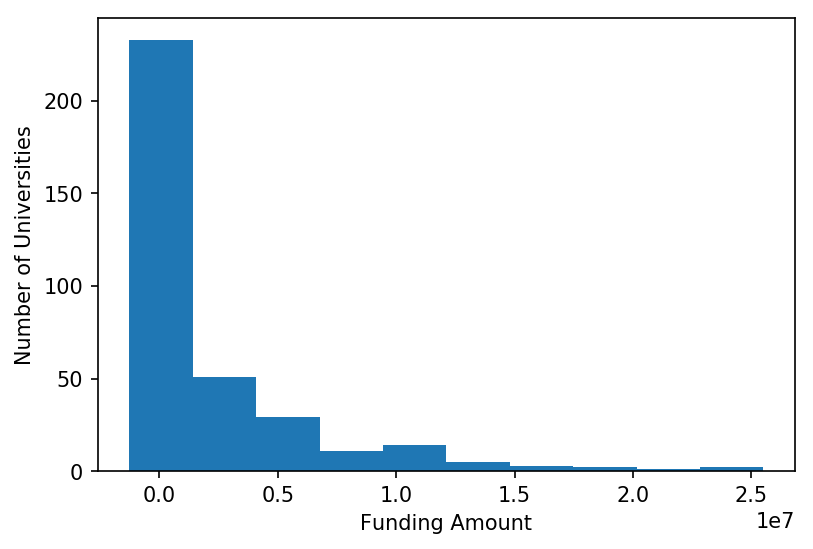

In [20]:
dod_weights = edge_weights['DEPARTMENT OF DEFENSE (DOD)']
plt.figure(dpi=150)
plt.hist(dod_weights)
plt.ylabel("Number of Universities")
plt.xlabel('Funding Amount')
plt.show()